In [1]:
#importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import gmsh
import time
import pylab as pl
import gmsh
from IPython import display
from matplotlib.path import Path
from scipy.sparse import coo_array
from collections import Counter
%matplotlib inline
import scipy

In [2]:
def read_mesh(filepath):
    '''
    Takes in an msh file and should return nodal coordinates and element connectivity in each physical group along with the boundary nodes 
    '''
    gmsh.initialize()
    gmsh.open(filepath)
    print(f"Reading {filepath}")
    print(f"Number of nodes in the mesh: {int(gmsh.option.getNumber("Mesh.NbNodes"))}")
    print(f"Number of triangles in the mesh: {int(gmsh.option.getNumber("Mesh.NbTriangles"))}\n")

    #Get all nodes
    dim = -1
    tag = -1
    nodeTags, nodecoords, _ = gmsh.model.mesh.getNodes(dim,tag)
    nodecoords = nodecoords.reshape(-1,3) #tags start from 1

    #Get all triangles
    eleType = 2
    tag = -1
    elements_t,ele_con = gmsh.model.mesh.getElementsByType(eleType,-1)
    ele_con = ele_con.reshape(-1,3)  #tags start from 1


    gmsh.finalize()
    return [nodecoords,ele_con] 

In [40]:
def Q(point,centre,ro):
    x = point[0,0] - centre[0,0]
    y = point[0,1] - centre[0,1]
    Qo = 5 ## amplitude in W/mm^2 
    return Qo*np.exp(-(x**2+y**2)/ro**2)  ## W/m^3

def rho_Ti(T, phase = 'alpha'):
    if phase == 'alpha':
        return -5.13e-5*(T**2)-0.01935*T+4451
    elif phase == 'beta':
        return -2.762e-6*(T**2)-0.1663*T+4468
    elif phase == 'liquid':
        return -0.565*T+5093
    else:
        return T

def cp_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.25*T+483
    elif phase == 'beta':
        return 0.14*T+530
    elif phase == 'liquid':
        return 930
    else:
        return T

def k_Ti(T,phase = 'alpha'):
    if phase == 'alpha':
        return 0.012*T+3.3
    elif phase == 'beta':
        return 0.016*T-3
    elif phase == 'liquid':
        return 0.0175*T-4.5
    else:
        return T
    

In [50]:
class FEM:
    def __init__(self):
        self.data_line = {"ips":{2:[-1/np.sqrt(3),1/np.sqrt(3)],3:[-np.sqrt(3/5),0,np.sqrt(3/5)]},\
        "weights":{2:[1,1],3:[5/9,8/9,5/9]}}
        self.data_tle = {"ips":{1:[[1/3,1/3]],3:[[1/6,1/6],[1/6,2/3],[2/3,1/6]]},\
       "weights":{1:[1/2],3:[1/6,1/6,1/6]}}
                        
    def fit_ele(self,nodes,ele,centre,theta_prev = None,mode = "linear"):
        '''
        Return mass and stiffness matrices alongside the forcing vector
        '''
        gp = 3

        qo = -1e-3   # W/mm^2
        c = 658 #J/kg.K
        rho = 7.6e-6 #kg/mm^3
        kappa = 0.025 #W/mm.K
        ro = 2 #mm
        vo = 2 #mm/s
        
        #getting in the required data and doing the initialization
        nop = nodes.shape[0]
        ips = np.array(self.data_tle["ips"][gp])
        weights = np.array(self.data_tle["weights"][gp])

        K = np.zeros((nop,nop))
        G = np.zeros((nop,nop))
        F = np.zeros((nop,1))
        boundary_term = np.zeros((nop,1))

        ln = np.where(nodecoords[:,0] == 0)[0]
        rn = np.where(nodecoords[:,0] == np.max(nodecoords[:,0]))[0]
        bn = np.where(nodecoords[:,1] == 0)[0]
        tn = np.where(nodecoords[:,1] == np.max(nodecoords[:,1]))[0]

        for i,elei in enumerate(ele):
            econ = elei-1
            boundary = nodes[np.ix_(econ,[0,1])]
            dN = np.array([[-1,1,0],[-1,0,1]])
            Jac = np.matmul(dN,boundary)
            if np.linalg.det(Jac)<0:
                econ[0],econ[1] = econ[1],econ[0] #reordering for the direction to be counter clockwise
                boundary = nodes[np.ix_(econ,[0,1])] 
                Jac = np.matmul(dN,boundary)
            dN_dx = (np.linalg.inv(Jac)@dN)[0].reshape(1,-1) #1x3
            Jac_inv = np.linalg.inv(Jac)
            for j,ipj in enumerate(ips):
                N = np.array([[(1-ipj[0]-ipj[1]), ipj[0],ipj[1]]])
                a = (Jac_inv@dN).T@(Jac_inv@dN)*(np.linalg.det(Jac))*weights[j]
                b = N.T@dN_dx*(np.linalg.det(Jac))*weights[j]
                if mode == "non_linear":
                    kappa = N@k_Ti(theta_prev[np.ix_(econ,[0])],phase = 'alpha')/1e3 ##m to mm
                    rho = N@rho_Ti(theta_prev[np.ix_(econ,[0])],phase = 'alpha')/1e9  ##m to mm
                    c = N@cp_Ti(theta_prev[np.ix_(econ,[0])],phase = 'alpha')
                K[np.ix_(econ,econ)] += kappa*a
                G[np.ix_(econ,econ)] += rho*c*vo*b
                X  =np.matmul(N,boundary)
                f = N*Q(X,centre,ro)*np.linalg.det(Jac)*weights[j]
                F[np.ix_(econ,[0])] +=f.T

            for l,m in zip([0,1,2],[1,2,0]):
                n1 = econ[l]
                n2 = econ[m]
                check_rn = (n1 in rn and n2 in rn)
                check_tn = (n1 in tn and n2 in tn)
                check_bn = (n1 in bn and n2 in bn)
                if check_rn or check_tn or check_bn:
                    # print(n1,'\t',n2)
                    line_gp = 3
                    line_ips = np.array(self.data_line["ips"][line_gp])
                    line_weights = np.array(self.data_line["weights"][line_gp])
                    for k,ipk in enumerate(line_ips):
                        N_line = np.array([(1-ipk)/2, (1+ipk)/2]).reshape(1,-1)
                        dN_line = np.array([-1/2, 1/2]).reshape(1,-1)
                        line_boundary = nodes[np.ix_([n1,n2],[1 if check_rn else 0])] #assuming interfacial lines are along x axis
                        Jac_line = np.matmul(dN_line,line_boundary)
                        if np.linalg.det(Jac_line)<0:
                            n1,n2 = n2,n1
                            line_boundary = nodes[np.ix_([n1,n2],[1 if check_rn else 0])] #interchanging nodes"
                            Jac_line = np.matmul(dN_line,line_boundary)
                        # print(np.linalg.det(Jac_line))
                        boundary_term[np.ix_([n1,n2],[0])] += N_line.T*np.linalg.det(Jac_line)*(-qo)*line_weights[k]

        T_l = 273+20
        non_ln = np.setdiff1d(np.arange(K.shape[0]),ln)
        rhs = F+boundary_term-T_l*np.sum((K[np.ix_(np.arange(K.shape[0]),ln)]+G[np.ix_(np.arange(K.shape[0]),ln)]),axis = 1).reshape(-1,1)
        K_sub = K[np.ix_(non_ln,non_ln)]
        G_sub = G[np.ix_(non_ln,non_ln)]
        rhs_sub = rhs[np.ix_(non_ln,[0])]

        theta_sub = np.linalg.inv(K_sub+G_sub)@(rhs_sub)

        theta = np.zeros((K.shape[0],1))+T_l
        theta[non_ln,:] = theta_sub.reshape(-1,1)
        
        return [K,G,F,boundary_term,theta]


In [42]:
soln1 = FEM()

In [43]:
mesh_size_factor = 2

In [16]:
filename = f"rectangle_{mesh_size_factor}.msh"
nodecoords,ele_con = read_mesh(filename) #node tags start from 1
K,G,F,boundary,theta = soln1.fit_ele(nodecoords,ele_con,np.array([[50,25]]))

Reading rectangle_2.msh
Number of nodes in the mesh: 1542
Number of triangles in the mesh: 2932



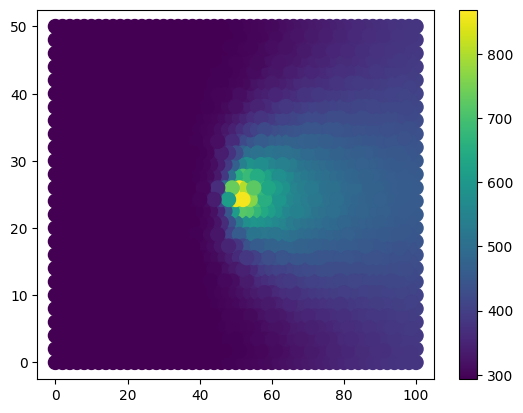

In [17]:
plt.scatter(nodecoords[:,0],nodecoords[:,1],c = theta, s= 100)
plt.colorbar()
plt.show()

## Picard iteration for moving source heat conduction

In [46]:
def picard(nodecoords,ele_con,theta_init):
## the idea is you initialize a temperature profile and find corresponding multipliers for the non linear terms
    #non is number of nodes
    theta_old = theta_init

    e = 1e5
    tolerance = 1e-4
    iter = 0
    
    while(e>tolerance):
        iter +=1
        _,_,_,_,theta_new = soln2.fit_ele(nodecoords,ele_con,np.array([[50,25]]),theta_prev = theta_old,mode = "non_linear")
        e = np.linalg.norm(theta_new - theta_old)
        theta_old = theta_new
        print(f"Error at {iter} iteration is {e:.2E}")

    plt.scatter(nodecoords[:,0],nodecoords[:,1],c = theta_new, s= 100)
    plt.title(f"Converged solution after {iter} iterations")
    plt.colorbar()
    plt.show()

    return theta_new
        
        

Error at 1 iteration is 9.69E+03
Error at 2 iteration is 2.09E+03
Error at 3 iteration is 3.06E+02
Error at 4 iteration is 3.48E+01
Error at 5 iteration is 5.13E+00
Error at 6 iteration is 6.39E-01
Error at 7 iteration is 8.67E-02
Error at 8 iteration is 1.16E-02
Error at 9 iteration is 1.44E-03
Error at 10 iteration is 2.06E-04
Error at 11 iteration is 2.36E-05


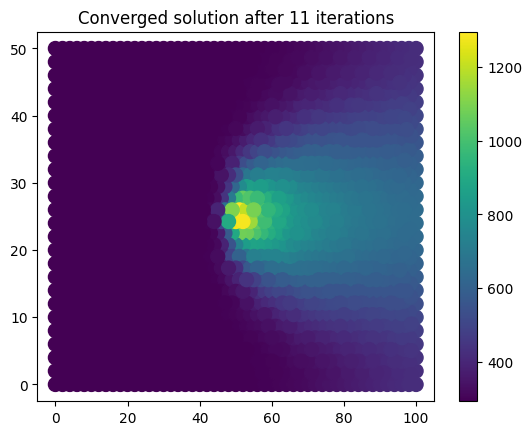

In [51]:
soln2 = FEM()
T_l = 273+20
theta_init = np.zeros((nodecoords.shape[0],1))+T_l
theta_final = picard(nodecoords,ele_con,theta_init)

In [53]:
np.max(theta_final)

np.float64(1295.8893185983738)